In [1]:
%matplotlib inline

import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_score, recall_score
from sklearn.datasets import load_breast_cancer, load_boston

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import preprocessing
from sklearn import utils


# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import itertools


In [2]:
d = pd.read_csv('data/cleaned_data_together.csv')
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df
df = df_cleaner(d)

In [4]:
df['MOY'] =df['DateTime']
df['WOY'] =df['DateTime']
def moy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return date.month
df['MOY'] = df['MOY'].apply(lambda x : moy(x))

In [88]:
df['Change'] = df['Henry Hub Price $/MMBtu'] - df['Henry Hub Price $/MMBtu'].shift(1)
df['Change']= df['Change'].fillna(0)

In [5]:
def woy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return int(date.strftime("%V"))
df['WOY'] = df['WOY'].apply(lambda x : woy(x))

In [6]:
df['one_week_back_temp'] = df['Temp'].shift(7).fillna(method= 'backfill')
df['two_week_back_temp'] = df['Temp'].shift(14).fillna(method= 'backfill')
df['three_week_back_temp'] = df['Temp'].shift(21).fillna(method= 'backfill')
df['four_week_back_temp'] = df['Temp'].shift(28).fillna(method= 'backfill')

In [7]:
df['one_back'] = df['Henry Hub Price $/MMBtu'].shift(1).fillna(method= 'backfill')
df['two_back'] = df['Henry Hub Price $/MMBtu'].shift(2).fillna(method= 'backfill')
df['three_back'] = df['Henry Hub Price $/MMBtu'].shift(3).fillna(method= 'backfill')
df['four_back'] = df['Henry Hub Price $/MMBtu'].shift(4).fillna(method= 'backfill')
df['five_back'] = df['Henry Hub Price $/MMBtu'].shift(5).fillna(method= 'backfill')

In [8]:
df['con_sto_diff'] = df['Storage BCFE'] - (df['Consumption MMCF']/1000)

In [9]:
df.head(2)

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,Change,MOY,...,one_week_back_temp,two_week_back_temp,three_week_back_temp,four_week_back_temp,one_back,two_back,three_back,four_back,five_back,con_sto_diff
0,2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1,NaN,1,...,26.0317,26.0317,26.0317,26.0317,5.82,5.82,5.82,5.82,5.82,1450.48
1,2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2,0.0,1,...,26.0317,26.0317,26.0317,26.0317,5.82,5.82,5.82,5.82,5.82,1450.48


In [10]:
DateTime = df.pop('DateTime').values

In [11]:
y = df.pop('Change').values

In [12]:
small_df= df[1600:2900]
small_y = y[1600:2900]

In [46]:
small_df.columns

Index(['Henry Hub Price $/MMBtu', 'Temp', 'Production MMCF', 'Storage BCFE',
       'Reserves BCFE', 'Consumption MMCF', 'DOY', 'MOY', 'WOY',
       'one_week_back_temp', 'two_week_back_temp', 'three_week_back_temp',
       'four_week_back_temp', 'one_back', 'two_back', 'three_back',
       'four_back', 'five_back', 'con_sto_diff'],
      dtype='object')

In [82]:
filt = ['Temp', 'Production MMCF', 'Storage BCFE',
       'Reserves BCFE', 'Consumption MMCF', 'DOY', 'MOY', 'WOY',
       'one_week_back_temp', 'two_week_back_temp', 'three_week_back_temp',
       'four_week_back_temp', 'one_back', 'two_back', 'three_back',
       'four_back', 'five_back', 'con_sto_diff']

In [83]:
Xs = small_df[filt].values

In [84]:
size = int(len(Xs) * 0.75)
X_train, X_test, y_train, y_test = Xs[0:size], Xs[size:len(Xs)], small_y[0:size], small_y[size:len(y)]

In [85]:
model = RandomForestRegressor()
depth_param = np.arange(1, 12, 1)
num_samples_param = np.arange(5,95,10)
n_trees = np.arange(1,70, 10)
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90], #, 100, 110
    'max_features': [2, 3, 4, 5, 10],
    'min_samples_leaf': [3, 4, 5, 10], #, 50, 90
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200] #, 300, 1000, 2000
}
clf = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
clf.fit(X_train,y_train)
print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

Accuracy score: -0.00404


In [69]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [80]:
X_train, X_test, y_train, y_test y_test
history_X = X_train
history_y = y_train
predictions = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,13)))
    yhat = output[0]
    predictions.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))
pred = np.array(predictions)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.00484


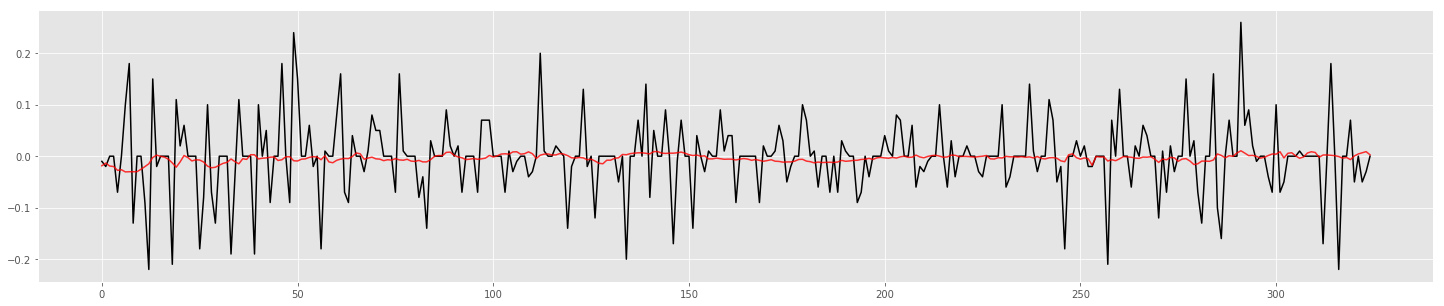

In [81]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(y_test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
#axs.set_xlim([20, 50])
#axs.set_ylim([-0.2, .2])
plt.show()

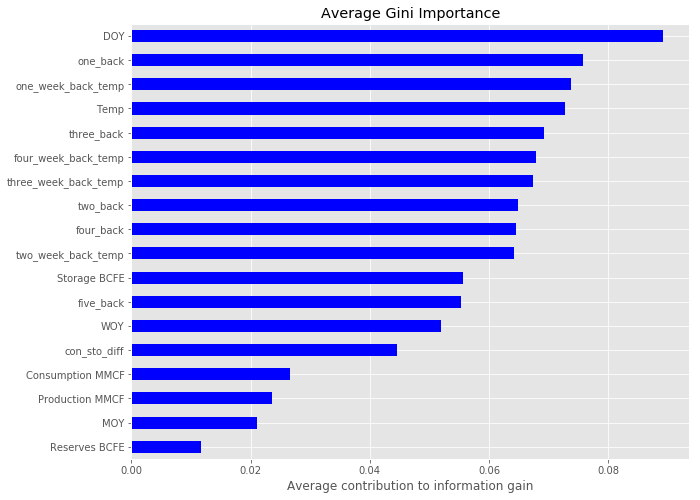

In [57]:
# Plot the feature importance
feat_scores = pd.Series(rfr.feature_importances_,
                           index=small_df[filt].columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [37]:
size = int(len(Xs) * 0.75)
HH_test = small_df['Henry Hub Price $/MMBtu'][size:len(y)]

In [39]:
len(HH_test), len(y_test)

(325, 325)

In [40]:
actual = HH_test + y_test

In [42]:
actual

2575    3.24
2576    3.21
2577    3.23
2578    3.23
2579    3.09
2580    3.16
2581    3.36
2582    3.62
2583    3.18
2584    3.31
2585    3.31
2586    3.13
2587    2.78
2588    3.30
2589    3.11
2590    3.13
2591    3.13
2592    3.13
2593    2.71
2594    3.14
2595    3.07
2596    3.17
2597    3.11
2598    3.11
2599    3.11
2600    2.75
2601    2.77
2602    3.05
2603    2.81
2604    2.62
        ... 
2870    3.16
2871    3.17
2872    3.17
2873    3.09
2874    2.99
2875    3.26
2876    3.02
2877    2.99
2878    3.04
2879    3.04
2880    3.04
2881    3.06
2882    3.05
2883    3.05
2884    3.05
2885    3.05
2886    3.05
2887    2.71
2888    2.88
2889    3.24
2890    3.06
2891    2.62
2892    2.84
2893    2.84
2894    2.98
2895    2.81
2896    2.86
2897    2.76
2898    2.75
2899    2.78
Name: Henry Hub Price $/MMBtu, Length: 325, dtype: float64